## Toxic Comment Classification TF/IDF Logistic Regression
Data base: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


#### Access drive and imports

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
import re, spacy, string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#### Load data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Data studying

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


#### Class distribution

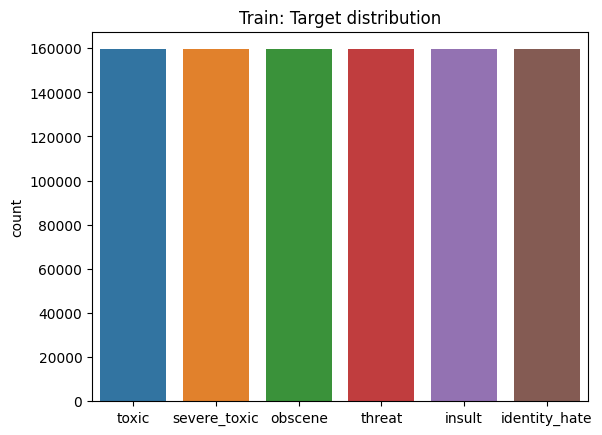

In [ ]:
sns.countplot(df_train);
plt.title('Train: Target distribution');

#### Amount positive points in class

In [ ]:
print(df_train.loc[df_train.toxic==1].shape[0])
print(df_train.loc[df_train.severe_toxic==1].shape[0])
print(df_train.loc[df_train.obscene==1].shape[0])
print(df_train.loc[df_train.threat==1].shape[0])
print(df_train.loc[df_train.insult==1].shape[0])
print(df_train.loc[df_train.identity_hate==1].shape[0])

15294
1595
8449
478
7877
1405


### Create y

In [ ]:
y = df_train.drop(['id','comment_text'],axis = 1)
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


### Load standart stopwords from nltk

In [ ]:
nltk.download('stopwords')
stopwords_ = stopwords.words('english')
stopwords_[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

#### Clearing the text from wrong words, links, etc.

In [ ]:
stemmer = SnowballStemmer(language='english')
def simple_clear(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub('<.*?>','',text)
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub('\[|\(.*\]|\)','', text) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)  
    text = text.split()
    text = [stemmer.stem(word) for word in text if not word in set(stopwords_)]
    text = ' '.join(text)
    return text

In [ ]:
df_train['clean'] = df_train['comment_text'].apply(simple_clear)
df_train['clean'][:5]

0    explan edit made usernam hardcor metallica fan...
1    aww match background colour seem stuck thank t...
2    hey man realli tri edit war guy constant remov...
3    make real suggest improv wonder section statis...
4                           sir hero chanc rememb page
Name: clean, dtype: object

### Create X

In [ ]:
X_raw = df_train['clean']
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42,shuffle = True)

### TF IDF and clearing text
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',                 
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words = stopwords_,
    sublinear_tf=True)

word_vectorizer.fit(X_train)

TfidfVectorizer(ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [ ]:
X_train_transformed = word_vectorizer.transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test)

#### Shape data

In [ ]:
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

X_train_transformed (127656, 5370994)
y_train (127656, 6)
X_test_transformed (31915, 5370994)
y_test (31915, 6)



### Logistic Regression and ROC AUC Score Metric


#### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
from collections import defaultdict
accuracy_data = defaultdict(list)
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train[col]
    model = LogisticRegression()
    model.fit(X_train_transformed, y)
    y_pred = model.predict(X_test_transformed)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_test[col], y_pred),5)))
    accuracy_data[col].append(round(accuracy_score(y_test[col], y_pred),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.95566
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98988
 
----prediction of obscene column----
 
Testing accuracy is 0.97713
 
----prediction of threat column----
 
Testing accuracy is 0.99765
 
----prediction of insult column----
 
Testing accuracy is 0.96892
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99138


#### ROC AUC Score in Toxic Label

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

**Can be applied to other labels**

In [ ]:
pipe_Log_reg =  Pipeline([("Log_reg", LogisticRegression(random_state = 42, max_iter = 10000))])
params = {'Log_reg__penalty': ['l2'],
          'Log_reg__C': [0.5,0.75,1],
          'Log_reg__class_weight': ['balanced',None],
          'Log_reg__solver': ['liblinear']}
Log_reg = GridSearchCV(pipe_Log_reg, params, scoring='roc_auc', return_train_score=True, n_jobs=-1)
Log_reg.fit(X_train_transformed, y_train.toxic)
print(f'Best_score = {Log_reg.best_score_}')
print(f'Best_params = {Log_reg.best_params_}')
print(f'Roc_auc at test:  = {roc_auc_score(y_test.toxic,Log_reg.predict(X_test_transformed))}')

Best_score = 0.9684099925307903
Best_params = {'Log_reg__C': 1, 'Log_reg__class_weight': 'balanced', 'Log_reg__penalty': 'l2', 'Log_reg__solver': 'liblinear'}
Roc_auc at test:  = 0.8973004907503879


In [ ]:
log_reg = LogisticRegression(C = 1, penalty='l2', solver = 'liblinear',class_weight = 'balanced', random_state=42)

classifier_ovr_log = OneVsRestClassifier(log_reg)
classifier_ovr_log.fit(X_train_transformed, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                 random_state=42,
                                                 solver='liblinear'))

In [ ]:
print("ROC AUC Score Test:", roc_auc_score(y_test, classifier_ovr_log.predict(X_test_transformed)))
print(classification_report(y_test, classifier_ovr_log.predict(X_test_transformed)))

ROC AUC Score Test: 0.9017540954418751
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      3056
           1       0.26      0.86      0.40       321
           2       0.67      0.89      0.77      1715
           3       0.18      0.78      0.29        74
           4       0.56      0.86      0.68      1614
           5       0.23      0.74      0.36       294

   micro avg       0.55      0.86      0.67      7074
   macro avg       0.43      0.83      0.54      7074
weighted avg       0.59      0.86      0.69      7074
 samples avg       0.06      0.08      0.07      7074



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
